In [28]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import env
import acquire
import features
import evaluate
import model

## Acquire and Prep
Created a function that acquired and prepped data from the Zillow Database. The minimum viable product is a model that examines the relationship between the Assessed Property Value of the desired housing units and the number of bathrooms, bedrooms, and square footage of the house. 

In [29]:
# def get_zillow_data_from_mysql():
   
#     # Use a double "%" in order to escape %'s default string formatting behavior.
#     query = '''Select props.`id` as property_id, 
#     props.`bathroomcnt` as bathroom_count,
#     props.`bedroomcnt` as bedroom_count,
#     props.`calculatedfinishedsquarefeet` as calc_finish_sq_ft,
#     props.`taxvaluedollarcnt` as assessed_property_value,
#     props.`taxamount` as tax_paid,
#     (props.`taxamount` / props.`taxvaluedollarcnt`) * 100 as tax_rate,
#     props.`fips` as county_code,
#     svi.`COUNTY` as county
#     from zillow.properties_2017 as props
#         JOIN zillow.predictions_2017 as pred
#         on zillow.props.id = zillow.pred.id
#     JOIN svi_db.`svi2016_us_county` as svi
#     on zillow.props.fips = svi_db.svi.fips
#     Where transactiondate like "2017-05%%" or transactiondate like "2017-06%%" 
#     and props.`propertylandusetypeid` not in (31, 246, 247, 248)
#     AND
#     props.`calculatedfinishedsquarefeet` IS NOT NULL
#     AND 
#     props.`bathroomcnt` != 0
#     AND
#     props.`bedroomcnt` != 0

#     '''



df = acquire.wrangle_zillow()
df

Reading data from ./zillow.csv


,property_id,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value,tax_paid,tax_rate,county_code,county
0,1772,2.0,4,1604.0,498347.0,6089.82,1.222004,6037,Los Angeles
1,2028,3.0,3,2384.0,549917.0,6679.55,1.214647,6037,Los Angeles
2,3273,2.0,3,1574.0,235272.0,3876.31,1.647587,6037,Los Angeles
3,3429,2.0,2,1619.0,340000.0,4206.15,1.237103,6037,Los Angeles
4,3908,3.0,3,1936.0,418146.0,5278.74,1.262416,6037,Los Angeles
5,4505,3.0,2,2408.0,2017254.0,24353.42,1.207256,6037,Los Angeles
7,5444,3.0,6,2610.0,381514.0,5708.90,1.496380,6037,Los Angeles
8,5931,2.0,4,1721.0,629951.0,6861.51,1.089213,6037,Los Angeles
9,6926,1.0,3,1136.0,305481.0,5488.23,1.796586,6037,Los Angeles
10,7018,1.0,2,1088.0,79930.0,1498.86,1.875216,6037,Los Angeles


# Prep 

__The prep work was accomplished in the acquire.py file. Cleaning started with the SQL query. After importing to jupyter notebook, rows with nulls were excluded.__



# Data Dictionary

In [ ]:
data_dict = {
    "bathroomcnt":"selected bathroomcnt because it was mandated and was the best selection ", 
    "bedroomcnt":"the bedroom count available in the database",
    "calculatedfinishedsquarefeet":"calculatedsqft had the least nulls and seemed to be the most accurate assessment of house size",
    "taxvaluedollarcnt":"this was the only assessed property tax value data",
    "taxamount":"shows how much tax was paid",
    "('taxamount` / `taxvaluedollarcnt`) * 100":"created a tax rate for each property",
    "`fips`":"provides the county code that can be merged with a join",
    "svi.`COUNTY`":"Allows the county name to be matched with the county code"
    
}

# Early visualization exploration
I wanted to see how the distribution of the independent variables looked


I wanted to get a sense of where the distributions of each variable lie to see if I could infer anything prior to running models

Also, not too proficient with data visualization, so it was good practice

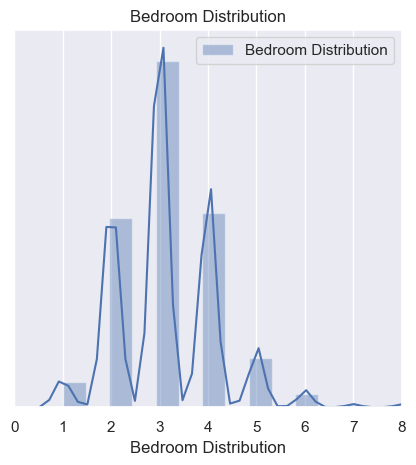

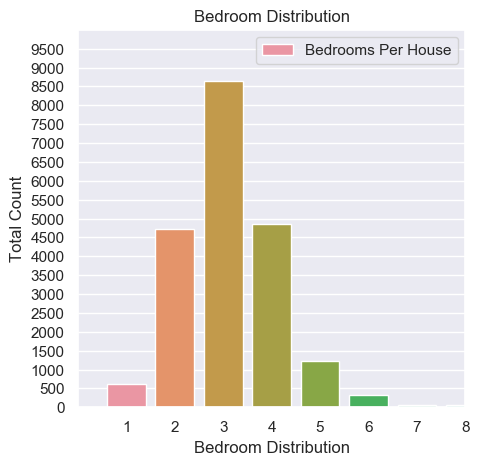

In [71]:
plt.figure(figsize = (5,5), dpi = 100)
sns.distplot(df['bedroom_count'], label = "Bedroom Distribution")
plt.xlim(0, 8)
plt.legend()
plt.yticks([])
plt.title("Bedroom Distribution")
plt.xlabel('Bedroom Distribution')
plt.show()


plt.figure(figsize = (5,5), dpi = 100)
sns.set(style="darkgrid")
ax = sns.countplot(x=df.bedroom_count, data=df, label = 'Bedrooms Per House')
plt.xlim(-1,7)
plt.ylim(0, 10000)
plt.ylabel("Total Count")
plt.legend()
plt.yticks(np.arange(0, 10000, step=500))
plt.title("Bedroom Distribution")
plt.xlabel('Bedroom Distribution')
plt.show()

# sns.catplot(x="Bedroom Number", y="Bedroom Count", data=df.sort_values('bedroom_count'))

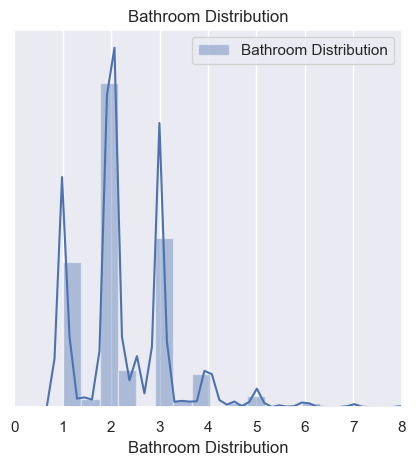

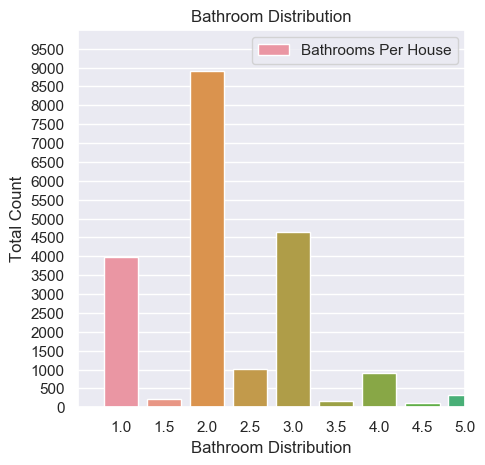

In [72]:
plt.figure(figsize = (5,5), dpi = 100)
sns.distplot(df['bathroom_count'], label = "Bathroom Distribution")
plt.xlim(0, 8)
plt.legend()
plt.yticks([])
plt.title("Bathroom Distribution")
plt.xlabel('Bathroom Distribution')
plt.show()


plt.figure(figsize = (5,5), dpi = 100)
sns.set(style="darkgrid")
ax = sns.countplot(x=df.bathroom_count, data=df, label = 'Bathrooms Per House')
plt.xlim(-1,8)
plt.ylim(0, 10000)
plt.ylabel("Total Count")
plt.legend()
plt.yticks(np.arange(0, 10000, step=500))
plt.title("Bathroom Distribution")
plt.xlabel('Bathroom Distribution')
plt.show()

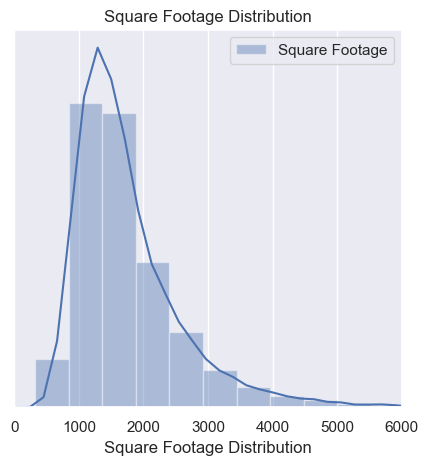

In [70]:
plt.figure(figsize = (5,5), dpi = 100)
sns.set(style="darkgrid")
sns.distplot(df['calc_finish_sq_ft'], label = 'Square Footage')
plt.legend()
plt.yticks([])
plt.xlim(0,6000)
plt.title("Square Footage Distribution")
plt.xlabel('Square Footage Distribution')
plt.show()

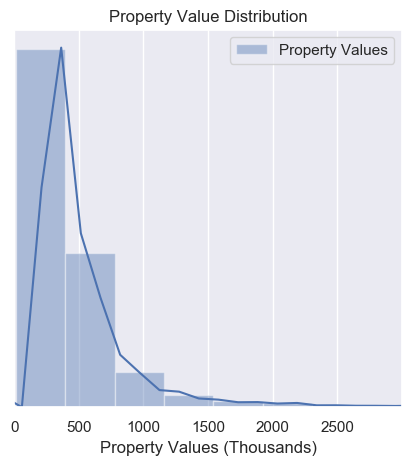

In [69]:
plt.figure(figsize = (5,5), dpi = 100)
sns.set(style="darkgrid")
sns.distplot((df['assessed_property_value']/1000), label = "Property Values")
plt.legend()
plt.yticks([])
plt.xticks(np.arange(0, 3_000, step = 500))
plt.xlim(0, 3000)
plt.title("Property Value Distribution")
plt.xlabel('Property Values (Thousands)')
plt.show()

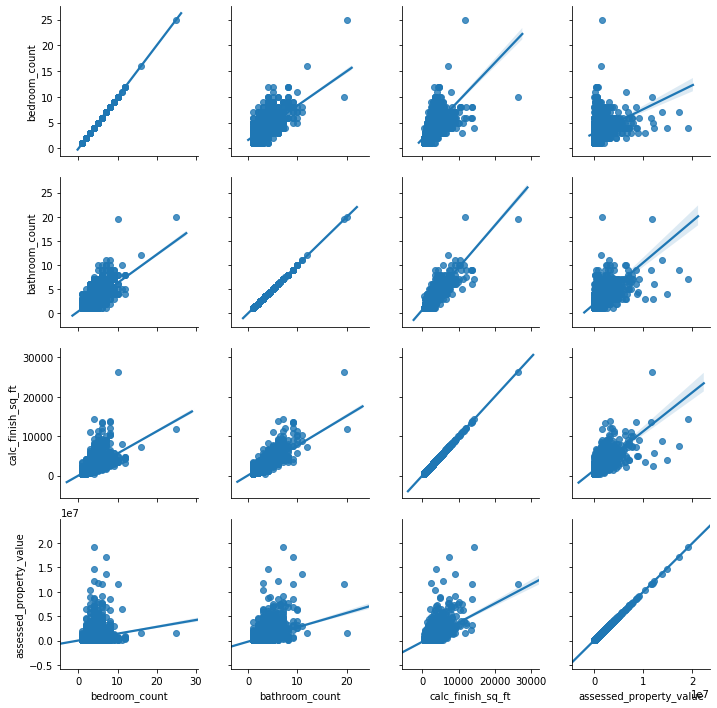

In [7]:
g=sns.PairGrid(df[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft', 'assessed_property_value']])
g.map(sns.regplot)
plt.show()

# Distribution of Tax Rates According to County
There were three counties that were identified in the query for this model: Los Angeles County, Orange County, and Ventura County.

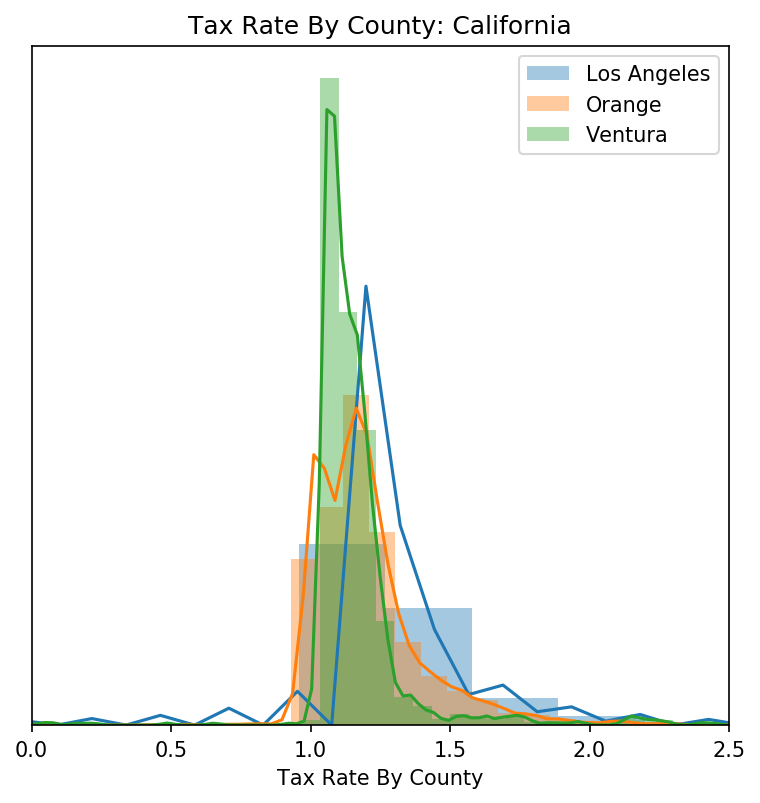

In [8]:
la_county = df.tax_rate[df.county == 'Los Angeles']
orange_county = df.tax_rate[df.county == 'Orange']
ventura_county = df.tax_rate[df.county == 'Ventura']

# len(la_county)
# len(orange_county)
# len(ventura_county)
plt.figure(figsize = (6,6), dpi = 150, facecolor = "w")
sns.distplot(la_county, label = "Los Angeles")
sns.distplot(orange_county, label = "Orange")
sns.distplot(ventura_county, label = "Ventura")
plt.xlim(0, 2.5)
plt.legend()
plt.yticks([])
plt.title("Tax Rate By County: California")
plt.xlabel('Tax Rate By County')
plt.show()

# Scaling the Data

__For data scaling, I am dropping some columns from the downloaded data set so I can create an MVP.__

__I will be creating a new dataframe so I can preserve the integrity of the original dataframe for future study__

In [10]:
# Dropping some columns for the split and scaling to create MVP, but 
# Creating a new dataframe so I can retain the other columns on reference

mvp_df = df.drop(['property_id', 'tax_paid', 'tax_rate', 'county_code', 'county'], axis = 1)
mvp_df.head()

,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value
0,2.0,4,1604.0,498347.0
1,3.0,3,2384.0,549917.0
2,2.0,3,1574.0,235272.0
3,2.0,2,1619.0,340000.0
4,3.0,3,1936.0,418146.0


# SPLIT SCALE NOTES

__The Split ratio is 0.8 and the seed is 123. Using anything else will cause different results__

In [11]:
## SPLIT AND SCALE ##
## SPLIT train_ratio of 0.8 and the seed of 123##
import split_scale

train, test = split_scale.split_my_data(mvp_df, train_ratio=.8, random_seed=123)


scaler, train_scaled, test_scaled = split_scale.standard_scaler(train,test)

X = mvp_df.drop(columns='assessed_property_value')

y = mvp_df['assessed_property_value']

X_train = train.drop(columns='assessed_property_value')

y_train = train[['assessed_property_value']]

X_test = test.drop(columns='assessed_property_value')

y_test = test[['assessed_property_value']]

Xtrain_scaled = train_scaled.drop(columns='assessed_property_value')

ytrain_scaled = train_scaled[['assessed_property_value']]

Xtest_scaled = test_scaled.drop(columns='assessed_property_value')

ytest_scaled = test_scaled[['assessed_property_value']]


## DATA EXPLORATION ###

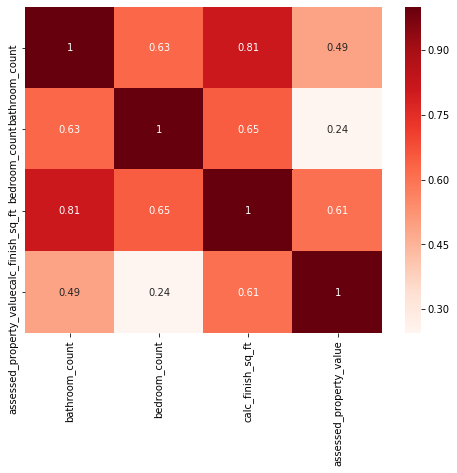

In [12]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [13]:
import statsmodels.api as sm

#OLS object to analyze features

ols_model = sm.OLS(y_train, Xtrain_scaled)
regr = sm.OLS(y, X).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     assessed_property_value   R-squared (uncentered):                   0.632
Model:                                 OLS   Adj. R-squared (uncentered):              0.632
Method:                      Least Squares   F-statistic:                          1.175e+04
Date:                     Sat, 19 Oct 2019   Prob (F-statistic):                        0.00
Time:                             23:07:27   Log-Likelihood:                     -2.9623e+05
No. Observations:                    20518   AIC:                                  5.925e+05
Df Residuals:                        20515   BIC:                                  5.925e+05
Df Model:                                3                                                  
Covariance Type:                 nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bathroom_count     4.183e+04   5309.646      7.877      0.000    3.14e+04    5.22e+04
bedroom_count     -1.476e+05   3023.278    -48.812      0.000   -1.53e+05   -1.42e+05
calc_finish_sq_ft   460.2266      5.890     78.141      0.000     448.682     471.771
==============================================================================
Omnibus:                    31016.239   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34079345.318
Skew:                           9.060   Prob(JB):                         0.00
Kurtosis:                     201.833   Cond. No.                     3.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Fitting the model and baseline 

In [14]:
from sklearn.linear_model import LinearRegression

predictions= pd.DataFrame({'actual':y_train.assessed_property_value}).reset_index(drop=True)

#Minimal Viable Product
lm1=LinearRegression()
lm1.fit(Xtrain_scaled[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft']],y_train)
lm1_predictions=lm1.predict(Xtrain_scaled[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft']])
predictions['lm1']=lm1_predictions

lm1_y_intercept = lm1.intercept_
# print("intercept: ", lm1_y_intercept)
lm1_coefficients = lm1.coef_
# print("coefficients: ", lm1_coefficients)


#Baseline
predictions['baseline'] = y_train.mean()[0]


In [15]:
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print("MSE =",MSE_baseline, "SSE =", SSE_baseline, "RMSE =", RMSE_baseline, "R2 =", r2_baseline)

MSE = 365466657221.37354 SSE = 5998769711631625.0 RMSE = 604538.3835798795 R2 = 0.0


In [16]:
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print("MSE =", MSE_1, "SSE=", SSE_1, "RMSE=", RMSE_1, "R2=", r2_1)

# len(predictions.baseline)

MSE = 215224192988.70938 SSE= 3532689903716676.0 RMSE= 463922.6153020667 R2= 0.41109759608427976


16414

# Analysis

__The MSE for the model returns a significantly lower result than for the baseline.__

__The r2 score is also markedly higher than the baseline r2, which reads 0.__

In [17]:
print('{} = b + m1 * {} + m2 * {} + m3 * {}'.format(y_train.columns[0], Xtrain_scaled.columns[0],Xtrain_scaled.columns[1],Xtrain_scaled.columns[2]))
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])
print('    coefficient (m3): %.2f' % lm1_coefficients[0][2])

assessed_property_value = b + m1 * bathroom_count + m2 * bedroom_count + m3 * calc_finish_sq_ft
    y-intercept  (b): 445764.83
    coefficient (m1): -162523.96
    coefficient (m2): 43463.17
    coefficient (m3): 438046.79


In [18]:
y_pred_lm1 = lm1.predict(Xtrain_scaled)
y_pred_lm1

array([[167317.31659355],
       [255107.8466537 ],
       [484076.08828638],
       ...,
       [164025.45568957],
       [464972.9242719 ],
       [ 45981.76062471]])

# Testing Data


In [20]:
model=lm1.predict(Xtest_scaled)
model=model.ravel().reshape(4104)
y_test1=np.array(y_test).ravel().reshape(4104)
best_model=pd.DataFrame({'predictions':model,'assessed_property_value':y_test1})

best_model.head()

,predictions,assessed_property_value
0,188103.717769,280022.0
1,92236.795043,218577.0
2,396309.866338,461934.0
3,83279.460709,55353.0
4,857486.216119,1360486.0


Text(0.5, 1, 'Predicted vs Actual Tax Value')

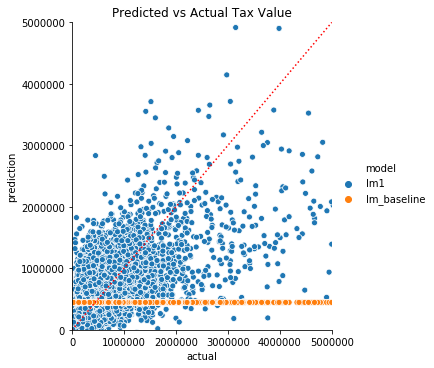

In [21]:
pd.DataFrame({'actual': predictions.actual,
              'lm1': predictions.lm1,
              'lm_baseline': predictions.baseline.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
min = 0
max = 5_000_000
plt.plot([min, max],[min, max], c='red', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')